# Lesson 8 - K-Means Clustering

The k-means algorithm falls in the category of unsupervised machine learning, where the input data points are not given a label and the algorithm has to "infer" a label from the data. K-Means is a clustering algorithm where the "label" is the cluster that an input data point belongs to.  It has been used to solve many problems such as:

- Anomaly detection
- Image segmentation
- Grouping of texts, images, videos
- Media compression

The belonging to a cluster concept is based on the similarity between the input data point and cluster point. Typically, similarity is expressed as the distance between the input data point and a cluster point, where the smaller the distance, the more similar the input data is to a cluster.

In k-means, the number of clusters (k) has to be specified, and each input data is assigned to one of the k clusters. It does this in an iterative manner as follows:

1. A set of k points with random values are defined the k cluster centroids.
2. For each input point, the distance to each centroid is calculated.  The point is assigned to the centroid with the smallest distance.
3. Update the centroid values based on the mean of the assigned points.
4. Repeat 2 and 3 until a terminating condition is triggered, such as a max number of iterations is reached, or the assignment of the input data to clusters has not changed.

Let's implement the above logic, but first importing the usual suspect:

In [1]:
%matplotlib inline
!conda install -y xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.6.1         |   py36h72c5cf5_0         606 KB  conda-forge
    numpy-1.11.3               |py36he5ce36f_1207         3.6 MB  conda-forge
    libblas-3.8.0              |       4_openblas           6 KB  conda-forge
    libcblas-3.8.0             |       4_openblas           6 KB  conda-forge
    libstdcxx-ng-8.2.0         |       hdf63c60_1         2.9 MB  defaults
    libgcc-ng-8.2.0            |       hdf63c60_1         7.6 MB  defaults
    pycurl-7.43.0.2            |   py36h1ba5d50_0         185 KB  defaults
    xgboost-0.82       

In [2]:
from sklearn.cluster import KMeans

In [71]:
# Do some data cleanup
import pandas as pd

train = pd.read_csv('train.csv')

m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])

train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

train = train[train['pickup_longitude'] <= -73.9]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.7]

inside = np.logical_and(np.logical_and(train['pickup_longitude'] >= -74.022, train['pickup_longitude'] <= -73.932),
                        np.logical_and(train['pickup_latitude'] >= 40.7, train['pickup_latitude'] <= 40.815))

outside_start = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.97, train['pickup_longitude'] <= -73.93),
                               np.logical_and(train['pickup_latitude'] <= 40.74, train['pickup_latitude'] >= 40.70))

outside_start1 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.96 , train['pickup_longitude'] <= -73.93),
                                np.logical_and(train['pickup_latitude'] <=40.75, train['pickup_latitude'] >=40.74))

outside_start2 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.95, train['pickup_longitude'] <= -73.93),
                                np.logical_and(train['pickup_latitude'] <= 40.76, train['pickup_latitude'] >= 40.74))

outside_start3 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.94, train['pickup_longitude'] <= -73.92),
                                np.logical_and(train['pickup_latitude'] <= 40.78, train['pickup_latitude'] >= 40.74))

outside_start4 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -74.02, train['pickup_longitude'] <= -74.01),
                                np.logical_and(train['pickup_latitude'] <= 40.79, train['pickup_latitude'] >= 40.77))

outside_start5 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.975, train['pickup_longitude'] <= -73.965),
                                np.logical_and(train['pickup_latitude'] <= 40.715, train['pickup_latitude'] >= 40.705))

outside_start6 = np.logical_and(np.logical_and(train['pickup_longitude'] >= -73.955, train['pickup_longitude'] <= -73.945),
                                np.logical_and(train['pickup_latitude'] <= 40.755, train['pickup_latitude'] >= 40.745))
                 

outside = [not c for c in outside_start]
outside1 = [not c for c in outside_start1]
outside2 = [not c for c in outside_start2]
outside3 = [not c for c in outside_start3]
outside4 = [not c for c in outside_start4]
outside5 = [not c for c in outside_start5]
outside6 = [not c for c in outside_start6]

both = np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(np.logical_and(inside, outside),outside1),outside2),outside3),outside4),outside5),outside6)

#mask = ((np.logical_and(40.7 <= train['pickup_latitude'], train['pickup_latitude']<=40.85)) & (np.logical_and(-74.022<=train['pickup_longitude'], train['pickup_longitude'] <=-73.932)))
#train = train[train['dropoff_longitude'] <= -73.75]
#train = train[train['dropoff_longitude'] >= -74.03]
#train = train[train['dropoff_latitude'] <= 40.85]
#train = train[train['dropoff_latitude'] >= 40.63]

all(inside)
all(outside)
#mlat = np.ma.masked_where(train['pickup_latitude'],train['pickup_longitude'], ~mask)
#mlon = np.ma.masked_where(train['pickup_longitude'], ~mask)

data = []
mlat = train['pickup_latitude'][both]
mlatc = mlat.values

mlon = train['pickup_longitude'][both]
mlonc = mlon.values

dlat = train['dropoff_latitude'][both]
dlatc = dlat.values

dlon = train['dropoff_longitude'][both]
dlonc = dlon.values

mtrip = train['trip_duration'][both]
mtripc = mtrip.values

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['Hour'] = train['pickup_datetime'].dt.hour
mhour = train['Hour'][both]
mhourc = mhour.values

data = {"plon": mlonc, "plat": mlatc, "dlon": dlonc, "dlat": dlatc, "tripd": mtripc, "hour": mhourc}
df = pd.DataFrame(data)

#chk = 0
#for i in inside:
#    if i == False:
#        print(chk)
#    chk +=1
#mlat


In [72]:
# Some new datetime-related fields
#train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
#pickup_date = train['pickup_datetime'].dt.date
#train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [73]:
# Time-related fields
#train['Month'] = train['pickup_datetime'].dt.month
#train['DayofMonth']  =  train['pickup_datetime'].dt.day
#train['Hour'] = train['pickup_datetime'].dt.hour
#train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
#mhour = train['Hour'][both]
#mhourc = mhour.values

In [74]:
# Part 1. Predict trip duration using clusetered pickup locations
# Fit the pickup locations
#stack = np.hstack((train[['pickup_longitude']].values, train[['pickup_latitude']].values))
stack = np.hstack((df[['plon']].values, df[['plat']].values))
kmNyc = KMeans(n_clusters=12).fit(stack[0:100000])

In [75]:
# Predict the pickup locations
c = []
c = kmNyc.predict(stack[0:100000])

Text(0,0.5,'latitude')

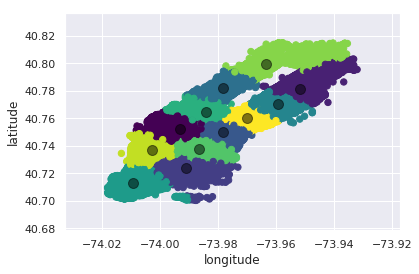

In [76]:
# Predict the clusters and get the cluster centroids
centers = kmNyc.cluster_centers_

plt.scatter(df['plon'][:100000], df['plat'][:100000], c=c, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.xlabel('longitude')
plt.ylabel('latitude')

In [77]:
# Predict trip duration using clustered pickup locations
X = pd.DataFrame(c)
y = df['tripd'][:100000]
dfc = pd.concat([X,y], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=7)

xgb_model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [78]:

y_pred = xgb_model.predict(X_valid)
r2_score(y_pred=y_pred, y_true=y_valid)


0.01202834774432826

In [79]:
xv = pd.DataFrame(X_valid.values,columns=['cluster'])
yp = pd.DataFrame(y_pred, columns=['trip_duration'])

submission = pd.concat([xv, yp], axis=1)

#submission = pd.DataFrame(X_valid)
#submission = pd.DataFrame(columns=['cluster', 'trip_duration'])
#submission.columns = ['cluster']
#submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
#submission['cluster'] = xw1
#submission['trip_duration'] = pd.DataFrame(y_pred)
#submission.reindex(columns=['cluster', 'trip_duration'])
#submission_plocs.csv', index=False)

sv = submission.values

cluster_ptr = 0
got_clusters = [0,0,0,0,0,0,0,0,0,0,0,0]
seen_clusters = 0
while seen_clusters < 12:
    this_cluster = sv[int(cluster_ptr)][0]
    #print (this_cluster)
    if got_clusters[int(this_cluster)] != 0:
        cluster_ptr += 1
        continue
    else:
        seen_clusters += 1
        got_clusters[int(this_cluster)] = sv[int(cluster_ptr),1]
        cluster_ptr += 1
        
ptr = 1
print('Trip duration predictions')
for cluster in got_clusters:
    print ('Cluster ' + str(ptr) + ',  prediction (seconds) is: ' + str(got_clusters[ptr-1]))
    ptr +=1

Trip duration predictions
Cluster 1,  prediction (seconds) is: 785.680175781
Cluster 2,  prediction (seconds) is: 699.84588623
Cluster 3,  prediction (seconds) is: 820.612854004
Cluster 4,  prediction (seconds) is: 763.333312988
Cluster 5,  prediction (seconds) is: 703.61328125
Cluster 6,  prediction (seconds) is: 707.730834961
Cluster 7,  prediction (seconds) is: 975.529968262
Cluster 8,  prediction (seconds) is: 827.174743652
Cluster 9,  prediction (seconds) is: 748.714782715
Cluster 10,  prediction (seconds) is: 726.602172852
Cluster 11,  prediction (seconds) is: 776.711853027
Cluster 12,  prediction (seconds) is: 738.001586914


In [80]:
# Part 2. Predict trip duration using pickup hour...using just pickup hour (this is extra)
hour_stack = np.hstack((df[['hour']].values))
hs = hour_stack[0:100000].reshape(-1,1)
kmNych = KMeans(n_clusters=6).fit(hs)

In [81]:
ch = kmNych.predict(hs)
ch

array([0, 3, 4, ..., 4, 2, 2], dtype=int32)

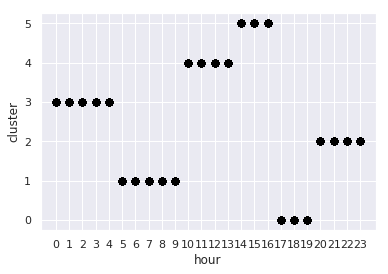

In [82]:
# Plot the aspatial hour clusters
centers = kmNych.cluster_centers_

fig, ax = plt.subplots()
plt.scatter(hour_stack[:100000], ch, c='black', s=40, cmap='viridis')
plt.xlabel('hour')
plt.ylabel('cluster')
ind = np.arange(24)
ax.set_xticks(ind)
indy = np.arange(6)
ax.set_yticks(indy)
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
#centers

In [83]:
# Part 2. Predict trip duration using hour and spatial
hour_stack = np.hstack((df[['plon']].values, df[['plat']].values, df[['hour']].values))
kmNych = KMeans(n_clusters=6).fit(hour_stack)

In [84]:
ch = kmNych.predict(hour_stack)
ch.size
chs = ch[0:1000]

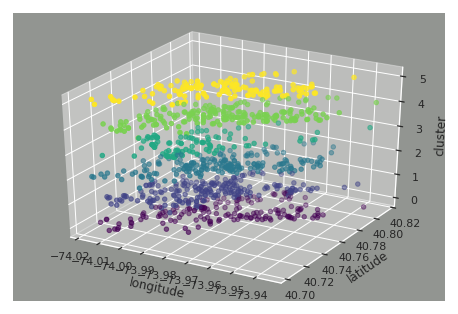

In [85]:
# Plot the clusters
centers = kmNych.cluster_centers_
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

# Plot the clusters
platp = df['plat'][0:1000]
plonp = df['plon'][0:1000]

ax.scatter(plonp,platp,chs,c=chs,cmap='viridis')
ax.set_xticks([-74.02, -74.01, -74.0,-73.99,-73.98,-73.97, -73.96, -73.95, -73.94])
ax.set_yticks([40.7,40.72, 40.74, 40.76, 40.78, 40.8, 40.82])
ax.set_zticks([0,1,2,3,4,5])
ax.set_facecolor('xkcd:gray')
plt.xlabel('longitude')
plt.ylabel('latitude')
ax.set_zlabel('cluster')

#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);

plt.show()

In [86]:
# Predict trip duration using clustered pickup hours
X = pd.DataFrame(ch[0:100000])
y = df['tripd']
X_train, X_valid, y_train, y_valid = train_test_split(X[0:100000], y[0:100000], test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=7)

xgb_model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [87]:
y_pred = xgb_model.predict(X_valid)
r2_score(y_pred=y_pred, y_true=y_valid)

0.0053549607916627551

In [88]:
xv = pd.DataFrame(X_valid.values,columns=['cluster'])
yp = pd.DataFrame(y_pred, columns=['trip_duration'])

submission = pd.concat([xv, yp], axis=1)

#submission = pd.DataFrame(X_valid)
#submission = pd.DataFrame(columns=['cluster', 'trip_duration'])
#submission.columns = ['cluster']
#submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
#submission['cluster'] = xw1
#submission['trip_duration'] = pd.DataFrame(y_pred)
#submission.reindex(columns=['cluster', 'trip_duration'])
#submission_plocs.csv', index=False)

sv = submission.values

cluster_ptr = 0
got_clusters = [0,0,0,0,0,0]
seen_clusters = 0
while seen_clusters < 6:
    this_cluster = sv[int(cluster_ptr)][0]
    #print (this_cluster)
    if got_clusters[int(this_cluster)] != 0:
        cluster_ptr += 1
        continue
    else:
        seen_clusters += 1
        got_clusters[int(this_cluster)] = sv[int(cluster_ptr),1]
        cluster_ptr += 1
        
ptr = 1
print('Trip duration predictions')
for cluster in got_clusters:
    print ('Cluster ' + str(ptr) + ',  prediction (seconds) is: ' + str(got_clusters[ptr-1]))
    ptr +=1

Trip duration predictions
Cluster 1,  prediction (seconds) is: 715.129577637
Cluster 2,  prediction (seconds) is: 746.629821777
Cluster 3,  prediction (seconds) is: 850.156677246
Cluster 4,  prediction (seconds) is: 712.217773438
Cluster 5,  prediction (seconds) is: 784.090759277
Cluster 6,  prediction (seconds) is: 805.316467285


In [89]:
#plat = train['pickup_latitude'].values
#plon = train['pickup_longitude'].values

#dlat = train['dropoff_latitude'].values
#dlon = train['dropoff_longitude'].values
#trip_duration = train['trip_duration'].values

In [90]:
#train['Month'] = train['pickup_datetime'].dt.month
#train['DayofMonth']  =  train['pickup_datetime'].dt.day
#train['Hour'] = train['pickup_datetime'].dt.hour
#train['dayofweek'] = train['pickup_datetime'].dt.dayofweek

In [91]:
# Part 3. Find similar Manhattan routes
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lon = lon2 - lon1
    d = np.sin(lat*0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon*0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h
df['hdist'] = haversine(df['plat'], df['plon'], df['dlat'], df['dlon'])
hdist = df['hdist'].values

In [92]:
#coords = np.hstack((train[['pickup_latitude']].values,
#                    train[['pickup_longitude']].values,
#                    train[['dropoff_latitude']].values,
#                    train[['dropoff_longitude']].values,
#                    train[['passenger_count']].values,
#                    train[['vendor_id']].values,
#                    train[['Month']].values,
#                    train[['DayofMonth']].values,
#                    train[['Hour']].values,
#                    train[['dayofweek']].values,
#                    train[['trip_duration']].values))
coords = np.hstack((df[['plat', 'plon']].values,
                    df[['dlat', 'dlon']].values,
                    df[['hdist']].values))
                    #train[['trip_duration']].values))
                    #train[['vendor_id']].values,
                    #train[['passenger_count']].values,
                    #train[['Month']].values,
                    #train[['DayofMonth']].values,
                    #train[['Hour']].values,
                    #train[['dayofweek']].values))

In [93]:
sample_ind = np.random.permutation(len(coords))[:100000]
kmNycR = KMeans(n_clusters=12).fit(coords[sample_ind])

In [57]:
#pickup_cluster = kmNycR.predict(train[['pickup_latitude', 'pickup_longitude']])
#dropoff_cluster = kmNycR.predict(train[['dropoff_latitude', 'dropoff_longitude']])

In [94]:
cR = kmNycR.predict(coords[sample_ind])

In [95]:
cR.size

100000

In [96]:
from sklearn.metrics import silhouette_samples, silhouette_score
ss_values = silhouette_score(coords[sample_ind],cR)

In [97]:
ss_values

0.51800246658393179

In [98]:
# Get data for similar Manhattan routes...this data will be used to create a feature class suitable for display in ArcGis Pro
f = open("coords.txt", "w")

hdist = df['hdist']
plat = df['plat']
plon = df['plon']
dlat = df['dlat']
dlon = df['dlon']
trip_duration = df['tripd']

max_iter = 100000
num_iter = 0
label_ctr = 0
max_label = 499
label = 1

label_ptr = 0

while num_iter < max_iter:
    if cR[num_iter] == label:
        if hdist[sample_ind[num_iter]] == 0.0:
            num_iter += 1
            continue
        
        #print (num_iter)
        #print(label)
        #print(label_ptr)
        
        label_ptr += 1
        
        f.write(str(plat[sample_ind[num_iter]]) + " " + str(plon[sample_ind[num_iter]]) + " " + str(dlat[sample_ind[num_iter]]) + " " + str(dlon[sample_ind[num_iter]]) + " " + str(trip_duration[sample_ind[num_iter]]) + "\n")
        label_ctr += 1
        if label_ctr > max_label:
            break
    num_iter += 1

f.close()